In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Test implementation of the Udwadia-Kalaba formulation

Based on Antunes & Debut paper.
Parameters are taken from section V. _Illustrative computations_

In [23]:
# String parameters
class String():
    """
    Class representing a string. Attributes and methods are added as required.
    The string is considered pinned at the nut and free at the bridge.
    """
    def __init__(self, length, tens, rho, stiffness, int_fric, avd, bdamp):
        self.length = length
        self.tension = tens
        self.rho = rho # mass per unit length
        self.velocity = np.sqrt(self.tension/self.rho)
        self.stiffness = stiffness
        self.mass = self.length * self.rho
        self.mod_mass = self.mass / 2
        self.internal_friction = int_fric
        self.air_visc_damp = avd
        self.bend_damp = bdamp
        
    def modal_freq(self, num):
        """
        Returns the num-th modal frequency.
        
        The formula has been slightly changed so that num=0 yields the fundamental
        frequency, in accordance to python numbering.
        """
        p_n = (2*num + 1)*np.pi/(2*self.length)
        freq_n = self.velocity*p_n/(2*np.pi) * (1 + self.stiffness* p_n**2/(2*self.tension))
        return freq_n
        
    def modal_freq_arr(self, num):
        """
        Returns an array of the num first modal frequencies.
        """
        arr = []
        for n in range(0, num):
            freq_n = self.modal_freq(n)
            arr.append(freq_n)
        return np.array(arr)
    
    def modal_puls(self, num):
        """
        Returns the num-th modal pulsation.
        """
        return 2*np.pi * self.modal_freq(num)
    
    def modal_puls_arr(self, num):
        """ 
        Returns an array of the num first modal pulsations.
        """
        return 2*np.pi*self.modal_freq_arr(num)
    
    def modeshape(self, num):
        """
        Returns a lambda function of the num-th modeshape.
        """
        modeshape = lambda x: np.sin((2*num + 1)*np.pi * x/(2*self.length))
        return modeshape
    
    def modal_damping(self, num):
        """
        Returns the num-th modal damping coefficient.
        """
        f_n = self.modal_freq(num)
        p_n = (2*num + 1)*np.pi/(2*self.length)
        numerator = self.tension*(self.internal_friction + self.air_visc_damp/(2*np.pi*f_n)) + self.bend_damp*self.stiffness*p_n**2
        denominator = 2*(self.tension + self.stiffness*p_n**2)
        return numerator/denominator
    
    def modal_damp_arr(self, num):
        """
        Returns an array of the num first modal damping coefficients.
        """
        arr = []
        for n in range(0, num):
            zeta_n = self.modal_damping(n)
            arr.append(zeta_n)
        return np.array(arr)
    
    def modal_mass_matrix(self, size):
        """
        Returns a square modal mass matrix.
        """
        mass_mat = np.eye(size)
        mass_mat = mass_mat * self.mod_mass
        return mass_mat
        
    def modal_damp_matrix(self, size):
        """
        Returns a square modal damping matrix.
        params:
            size(int): Size of the matrix.
        returns:
            damp_mat(np.array): Diagonal matrix of modal damping parameters.
        """
        damp_vec = 2 * self.mod_mass * self.modal_puls_arr(size) * self.modal_damp_arr(size)
        return np.diag(damp_vec)
    
    def modal_stiff_matrix(self, size):
        """
        Returns a square modal stiffness matrix.
        params:
            size(int): Size of the matrix.
        returns:
            damp_stif(np.array): Diagonal matrix of modal stiffness parameters.
        """
        stif_vec = self.mod_mass * np.power(self.modal_puls_arr(size), 2)
        return np.diag(stif_vec)
    
    def modal_forces(self, force, size):
        """
        Project a force field on the modeshapes.
        params:
            force(np.array): Force field on the string. It should be 1D with each point
                separated by the geometrical sampling;
            size(int): the number of modes considered.
        returns:
            mod_forces(np.array): size x 1 array of the force field projected
                on the modeshapes.
        """
        geom_samples = np.linspace(0, self.length, len(force))
        modeshapes_mat = self.modeshape(0)(geom_samples)
        for mode in range(1, size):
            modeshape_vec = self.modeshape(mode)(geom_samples)
            modeshapes_mat = np.stack((modeshapes_mat, modeshape_vec))
        mod_forces = np.dot(modeshapes_mat, force[:, np.newaxis])
        return mod_forces

In [19]:
L = 0.65
T = 73.9
rho = 3.61e-3
B = 4e-5
etaF = 7e-5
etaA = 0.9
etaB = 2.5e-2
corde = String(L, T, rho, B, etaF, etaA, etaB)

In [20]:
N = 1000

<IPython.core.display.Javascript object>


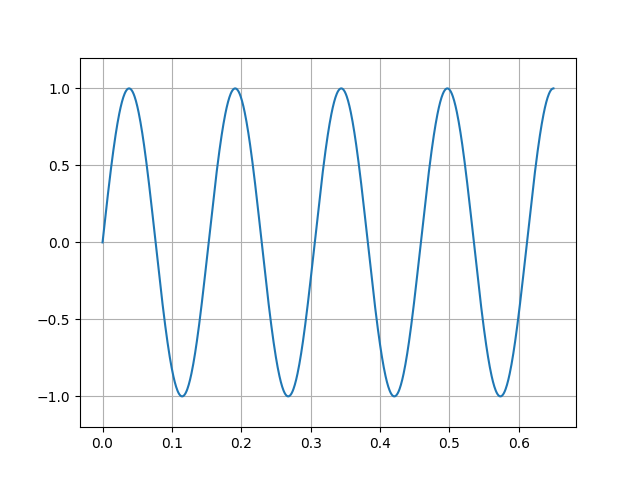

In [21]:
plt.figure()
points = np.linspace(0, corde.length, N)
plt.plot(points, corde.modeshape(8)(points))
plt.ylim(-1.2, 1.2)
plt.grid()
plt.show()

## Udwadia Kalaba, modal formulation
### Computation of the modal parameters

In [ ]:
class ModalUK():
    def __init__(self, mass_mat, damp_mat, stif_mat):
        """
        mass_mat = M;
        damp_mat = C;
        stif_mat = K;
        ext_force_mod_mat = F_ext_modal;
        """
        self.mass_mat = mass_mat
        self.damp_mat = damp_mat
        self.stif_mat = stif_mat
    
    def modal_forces_unconstrained(self, pos, pos_dot, f_ext_mod):
        """
        Implements equation (34).
        params:
            pos(np.array): displacement;
            pos_dot(np.array): velocity;
            f_ext_mod(np.array): vector of modal ext forces
        """
        